In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tsai.all import *

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16
Total RAM      : 31.17 GB
Available RAM  : 24.42 GB



In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = ""#"sample"

In [4]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


In [5]:
transformed_dataset = ConcatDataset([dmel1, dsuz1])
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

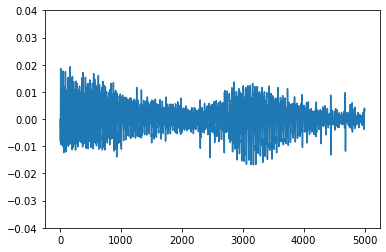

In [6]:
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [7]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
elif modeltype == 'conv1draw':
    model = Conv1dNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)
# print(model)

In [8]:
# list(model.children())[0]

In [9]:
# test if everything works with mock input
# import torchsummary
# torchsummary.summary(model, (1,10000))
# x = torch.randn(32, 1, 5000)

# output = model(x)
# output

## Training

In [10]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Train on gpu: True


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (inf --> 4.707845).  Saving model ...
Epoch 0: train_acc: 88.43% loss: 0.118,  val_loss: 4.708 val_acc: 59.52%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (4.707845 --> 1.949193).  Saving model ...
Epoch 1: train_acc: 92.35% loss: 0.076,  val_loss: 1.949 val_acc: 56.64%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (1.949193 --> 0.686846).  Saving model ...
Epoch 2: train_acc: 93.28% loss: 0.056,  val_loss: 0.687 val_acc: 69.62%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 3: train_acc: 94.13% loss: 0.045,  val_loss: 0.899 val_acc: 64.93%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.686846 --> 0.262318).  Saving model ...
Epoch 4: train_acc: 94.66% loss: 0.032,  val_loss: 0.262 val_acc: 83.75%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 5: train_acc: 95.12% loss: 0.021,  val_loss: 7.431 val_acc: 43.78%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 6: train_acc: 95.49% loss: 0.012,  val_loss: 7.982 val_acc: 40.38%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 7: train_acc: 95.89% loss: 0.010,  val_loss: 5.818 val_acc: 47.81%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8: train_acc: 96.41% loss: 0.011,  val_loss: 14.108 val_acc: 40.54%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.262318 --> 0.097025).  Saving model ...
Epoch 9: train_acc: 97.75% loss: 0.008,  val_loss: 0.097 val_acc: 93.91%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 10: train_acc: 98.14% loss: 0.005,  val_loss: 0.543 val_acc: 81.79%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 11: train_acc: 98.28% loss: 0.004,  val_loss: 0.099 val_acc: 93.80%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.097025 --> 0.015180).  Saving model ...
Epoch 12: train_acc: 98.46% loss: 0.002,  val_loss: 0.015 val_acc: 97.32%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 13: train_acc: 98.71% loss: 0.002,  val_loss: 1.884 val_acc: 72.58%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 14: train_acc: 98.78% loss: 0.002,  val_loss: 0.102 val_acc: 94.72%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 15: train_acc: 98.96% loss: 0.001,  val_loss: 3.029 val_acc: 68.49%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 1.0000e-04.
Epoch 16: train_acc: 99.11% loss: 0.001,  val_loss: 0.199 val_acc: 90.00%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 17: train_acc: 99.27% loss: 0.001,  val_loss: 0.016 val_acc: 97.02%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.015180 --> 0.004629).  Saving model ...
Epoch 18: train_acc: 99.35% loss: 0.001,  val_loss: 0.005 val_acc: 97.17%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.004629 --> 0.004375).  Saving model ...
Epoch 19: train_acc: 99.36% loss: 0.001,  val_loss: 0.004 val_acc: 97.19%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 20: train_acc: 99.41% loss: 0.002,  val_loss: 0.006 val_acc: 97.27%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 21: train_acc: 99.44% loss: 0.002,  val_loss: 0.007 val_acc: 97.19%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.004375 --> 0.004369).  Saving model ...
Epoch 22: train_acc: 99.41% loss: 0.001,  val_loss: 0.004 val_acc: 97.29%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 23: train_acc: 99.42% loss: 0.001,  val_loss: 0.013 val_acc: 97.11%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 24: train_acc: 99.44% loss: 0.001,  val_loss: 0.008 val_acc: 97.22%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.004369 --> 0.003902).  Saving model ...
Epoch 25: train_acc: 99.49% loss: 0.002,  val_loss: 0.004 val_acc: 97.24%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.003902 --> 0.003854).  Saving model ...
Epoch 26: train_acc: 99.45% loss: 0.002,  val_loss: 0.004 val_acc: 97.24%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 27: train_acc: 99.48% loss: 0.001,  val_loss: 0.007 val_acc: 97.22%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.003854 --> 0.003614).  Saving model ...
Epoch 28: train_acc: 99.52% loss: 0.002,  val_loss: 0.004 val_acc: 97.29%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.003614 --> 0.003335).  Saving model ...
Epoch 29: train_acc: 99.53% loss: 0.002,  val_loss: 0.003 val_acc: 97.09%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 30: train_acc: 99.58% loss: 0.001,  val_loss: 0.009 val_acc: 97.24%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 31: train_acc: 99.52% loss: 0.001,  val_loss: 0.003 val_acc: 97.14%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 32: train_acc: 99.58% loss: 0.001,  val_loss: 0.012 val_acc: 97.02%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch    34: reducing learning rate of group 0 to 1.0000e-05.
Epoch 33: train_acc: 99.61% loss: 0.002,  val_loss: 0.005 val_acc: 97.17%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 87.05it/s] 

Epoch 34: train_acc: 99.56% loss: 0.001,  val_loss: 0.005 val_acc: 97.17%


## Testing

### testing on datasets with same conditions

In [11]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

Train on gpu: True


In [12]:
test_dataset = ConcatDataset([dmel2, dsuz2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

def test(model, loader):
    correct_test = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader, desc='Testing..\t'):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
    test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
    print(test_accuracy)

In [13]:
test(model,test_dataloader)

Testing..	: 100%|██████████| 418/418 [00:55<00:00,  7.54it/s]

91.61184210526315


In [14]:
@torch.no_grad()
def get_all_preds(model, loader):
#     model = model.to('cuda', dtype=torch.float)
    model.eval()

    results = {}
    results['preds'] = torch.tensor([])
    results['fnames'] = ()
    results['labels'] = torch.tensor([])
    results['idx'] = torch.tensor([])

    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)

        results['fnames'] += path_batch
        results['labels'] = torch.cat( (results['labels'], y_batch), dim=0)
        results['idx'] = torch.cat( (results['idx'], idx_batch), dim=0)

        preds = model(x_batch.float())
        results['preds'] = torch.cat(
            (results['preds'], preds)
            ,dim=0
        )
    return results

def softmax_out(x):
    return np.argmax(F.softmax(x.reshape(1,-1), dim=1), axis=1).tolist()[0]

### testing on ALL available datasets (collected with the same sensor)

In [18]:
ds1 = WingbeatsDataset(dsname="Suzukii_RL/R", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
ds2 = WingbeatsDataset(dsname="Suzukii_RL/L", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
ds3 = WingbeatsDataset(dsname="Melanogaster_RL/X", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
ds4 = WingbeatsDataset(dsname="Melanogaster_RL/W", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))

ds5 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
ds6 = WingbeatsDataset(dsname="Suzukii_RL/X", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

Found 10110 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14156 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 407 in dataset: Melanogaster_RL/X, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 742 in dataset: Melanogaster_RL/W, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


In [19]:
dslist = [ds1, ds2, ds3, ds4] # ALL_ΜEBIOS

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	: 100%|██████████| 398/398 [01:00<00:00,  6.59it/s]

93.45163316582915


In [20]:
dslist = [ds1, ds2, ds3, ds4, ds5, ds6] # ALL_HERENT + ALL_MEBIOS

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	: 100%|██████████| 815/815 [00:05<00:00, 152.00it/s]

92.5728527607362


In [21]:
dslist = [ds1, ds2] # ONLY_MEBIOS (summer - suz_rl)

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	: 100%|██████████| 380/380 [00:02<00:00, 139.49it/s]

93.71299342105263


In [22]:
dslist = [ds3, ds4] # ONLY_MEBIOS (autumn - mel_xw)

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	: 100%|██████████| 18/18 [00:00<00:00, 32.99it/s]

87.93402777777779


In [16]:
model = model.to('cpu', dtype=torch.float)

# dslist = [ds1, ds2, ds3, ds4, ds5, ds6]
# test_dataset = ConcatDataset(dslist)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

results = get_all_preds(model, test_dataloader)



results['preds_labels'] = list(map(softmax_out, results['preds']))

100%|██████████| 418/418 [01:16<00:00,  5.48it/s]


In [17]:
df = pd.DataFrame(results)
df['humidity'] = df.fnames.apply(lambda x: x.split('/')[-1].split('_')[-1][:-4]).astype(float).values
df['temperature'] = df.fnames.apply(lambda x: x.split('/')[-1].split('_')[-3]).astype(float).values
df.sample(3)

,preds,fnames,labels,idx,preds_labels,humidity,temperature
11406,"(tensor(10.6894), tensor(-10.8170))",/home/kalfasyan/data/wingbeats/Melanogaster_RL/Y/D_20_11_07_13_15_24/F201107_140131_208_G_050_T_22.5_H_-5.0.wav,0.0,11406.0,0,-5.0,22.5
17209,"(tensor(-9.6694), tensor(9.4654))",/home/kalfasyan/data/wingbeats/Suzukii_RL/X/D_21_01_24_12_14_53/F210124_125653_103_G_050_T_21.1_H_29.2.wav,1.0,5206.0,1,29.2,21.1
6781,"(tensor(2.4287), tensor(-2.4522))",/home/kalfasyan/data/wingbeats/Melanogaster_RL/Y/D_20_11_14_23_31_30/F201114_235944_000_G_050_T_22.5_H_1.3.wav,0.0,6781.0,0,1.3,22.5


## Plotting

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()
ticklabels = ['Melanogaster','Suzukii']

True vs Predicted


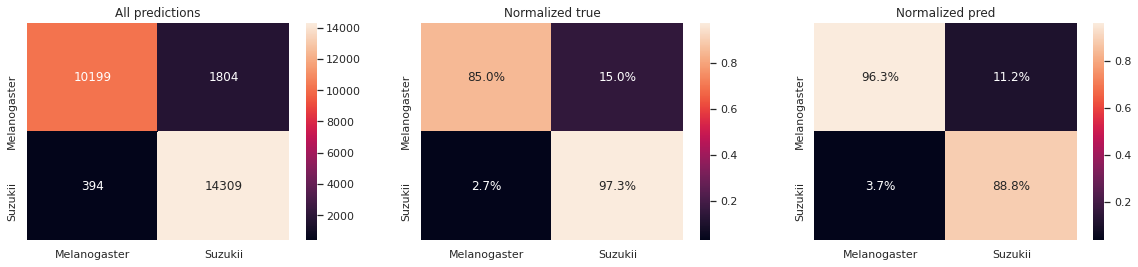

In [19]:
plt.figure(figsize=(20,4));
print("True vs Predicted")
plt.subplot(1,3,1); 
plt.title('All predictions');
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize=None)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=ticklabels, yticklabels=ticklabels);
plt.subplot(1,3,2); 
plt.title('Normalized true')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='true')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);
plt.subplot(1,3,3); 
plt.title('Normalized pred')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='pred')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);

True vs Predicted


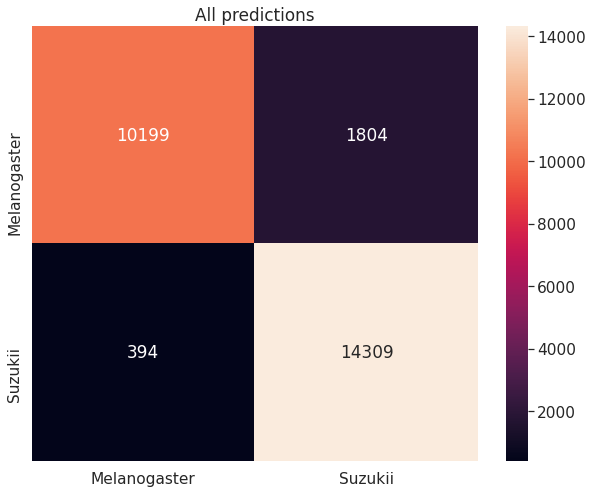

In [25]:
plt.figure(figsize=(34,8));
sns.set(font_scale=1.4)
print("True vs Predicted")
plt.subplot(1,3,1); 
plt.title('All predictions');
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize=None)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=ticklabels, yticklabels=ticklabels);
plt.savefig('/home/kalfasyan/Dropbox/to_send/cm_all.png', bbox_inches='tight', format='png')

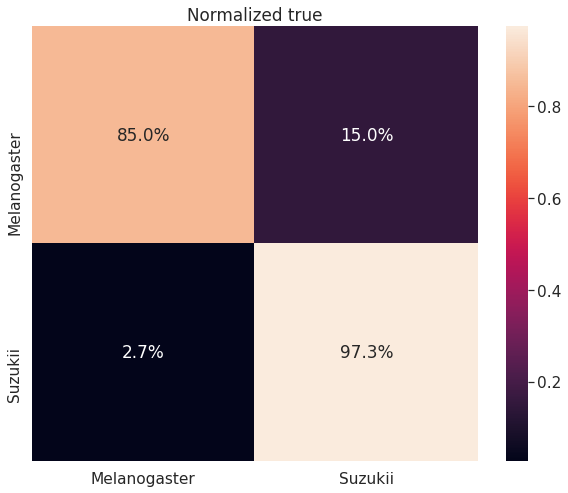

In [29]:
plt.figure(figsize=(34,8));
sns.set(font_scale=1.4)
plt.subplot(1,3,1); 

plt.title('Normalized true')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='true')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);
plt.savefig('/home/kalfasyan/Dropbox/to_send/cm_truenorm.png', bbox_inches='tight', format='png')

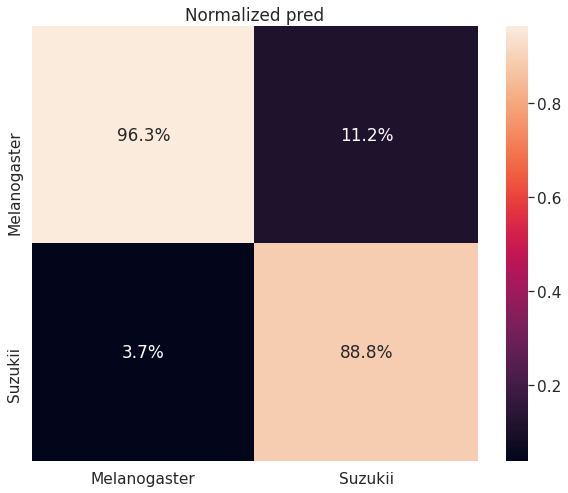

In [30]:
plt.figure(figsize=(34,8));
sns.set(font_scale=1.4)
plt.subplot(1,3,1); 
plt.title('Normalized pred')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='pred')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);
plt.savefig('/home/kalfasyan/Dropbox/to_send/cm_prednorm.png', bbox_inches='tight', format='png')

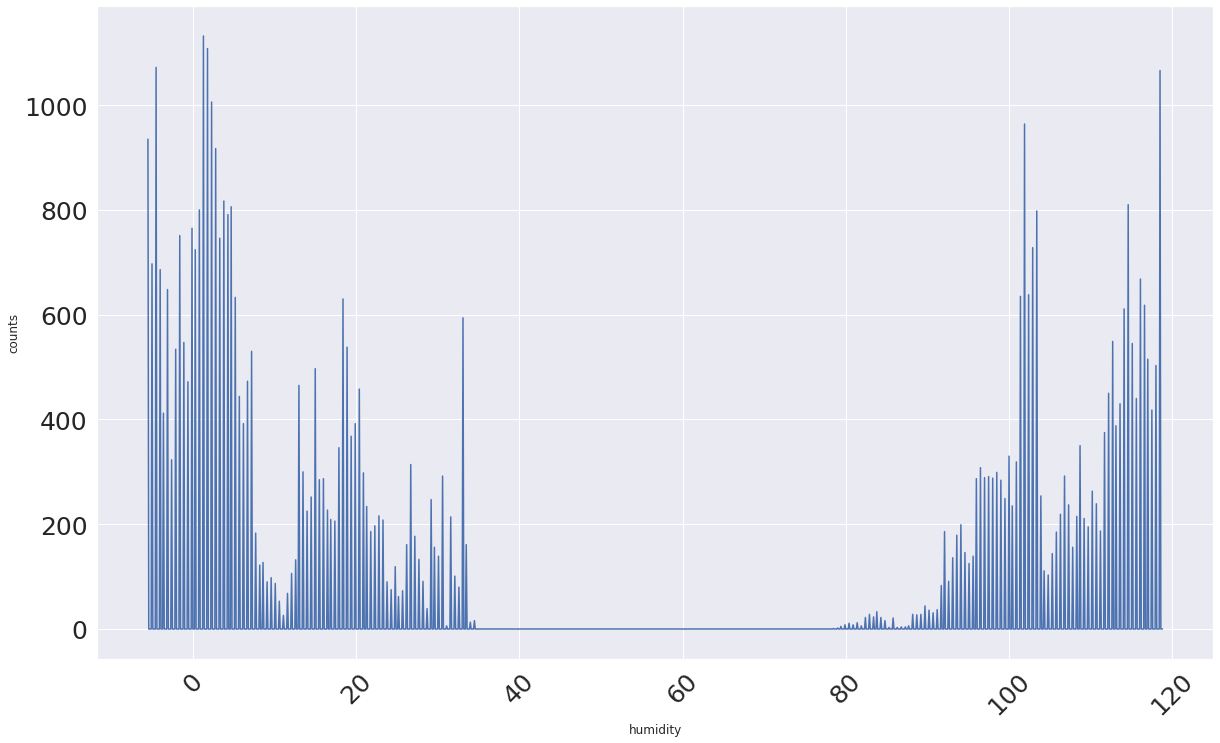

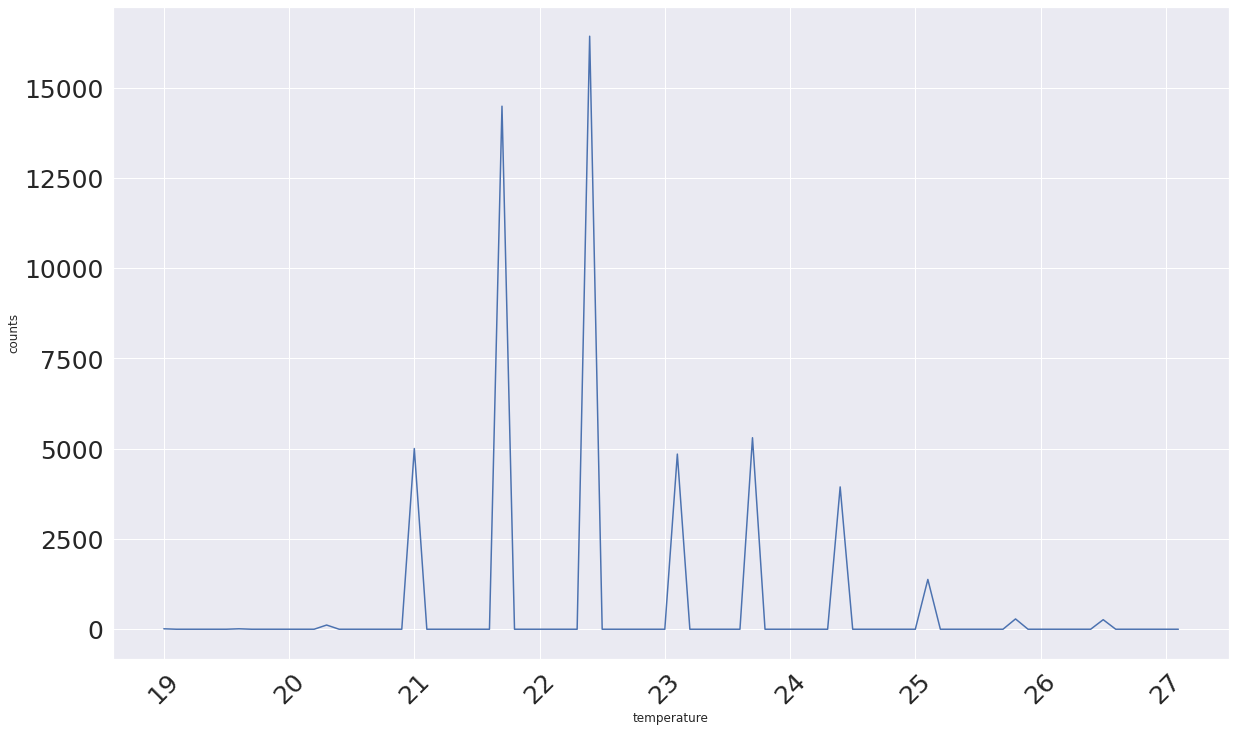

In [27]:
from utils import np_hist
plt.figure(figsize=(20,12))
np_hist(df, 'humidity', fs=25)
plt.figure(figsize=(20,12))
np_hist(df, 'temperature', fs=25)